In [1]:

# sys.path.append(os.path.abspath(os.path.join('..', 'vap_sound/src')))

In [2]:
import sys
import os

from glob import glob
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

from dotenv import load_dotenv

from vap_sound.utils.evaluate_model import evaluate_model


load_dotenv()


# MODEL_PATH = os.environ.get("MODEL_PATH")
MODEL_PATH = "vap_model1.pkl"
# LOG_MODEL_EVALUATION = os.environ.get("LOG_MODEL_EVALUATION")
LOG_MODEL_EVALUATION = "../logs/model_evaluation1.log"

# LOG_MODEL_PREDICTION = os.environ.get("LOG_MODEL_PREDICTION")
LOG_MODEL_PREDICTION = "../logs/model_prediction1.log"

In [3]:
import pickle

# Function to save model as pickle file
def save_model_pickle(model, path):
    with open(path, "wb") as f:
        pickle.dump(model, f)
    print("Model saved successfully as pickle file!")

# Function to load model from pickle file
def load_model_pickle(path):
    with open(path, "rb") as f:
        model = pickle.load(f)
    model.eval()
    print("Model loaded successfully from pickle file!")
    return model

In [4]:
## Model definition

import torch
import torch.nn as nn

# Model
class VAPModel(nn.Module):
    def __init__(self, input_dim=40, hidden_dim=128, lstm_hidden_dim=256, num_heads=10, num_layers=6, output_dim=1):
        super(VAPModel, self).__init__()
        
        # Transformer layer
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=input_dim, nhead=num_heads),
            num_layers=num_layers
        )
        
        # LSTM Layer 
        self.lstm = nn.LSTM(input_dim, lstm_hidden_dim, batch_first=True)
        
        # Fully connected layer to produce final output
        self.fc = nn.Linear(lstm_hidden_dim, output_dim)
    
    def forward(self, x):
        x = self.transformer(x)
        x, _ = self.lstm(x)
        x = self.fc(x)
        return torch.sigmoid(x)

In [5]:
from torch.utils.data import Dataset, DataLoader
import torch

# Collating data for training  --> Input is Pandas DataFrame
class VAPDataset(Dataset):
    def __init__(self, data_df, seq_length=100):
        # if isinstance(csv_files, str):
        #     csv_files = [csv_files]
        
        self.seq_length = seq_length
        # self.data = pd.concat([pd.read_csv(f) for f in csv_files], ignore_index=True)
        self.features = [torch.tensor(f) for f in data_df['features']]
        self.labels = [torch.tensor(l) for l in data_df['labels']]
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        feature = self.features[idx]
        label = self.labels[idx]
        
        if feature.shape[0] > self.seq_length:
            feature = feature[-self.seq_length:]
            label = label[-self.seq_length:]
        else:
            pad_length = self.seq_length - feature.shape[0]
            feature = torch.cat([torch.zeros(pad_length, feature.shape[1]), feature], dim=0)
            label = torch.cat([torch.zeros(pad_length, label.shape[1]), label], dim=0)
        
        return feature, label

In [6]:
# Collate function to pad variable-length sequences
def collate_fn(batch):
    features, labels = zip(*batch)
    features_padded = pad_sequence(features, batch_first=True, padding_value=0)
    labels_padded = pad_sequence(labels, batch_first=True, padding_value=0)
    return features_padded, labels_padded

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

model1 = VAPModel()


# Training function
def train_model(training_data, batch_size=16, epochs=10, seq_length=100, learning_rate = 0.01, model=model1):
    """
    Train the model using the provided training data.

    Args:
        model (nn.Module): The model to train.
        training_data (pd.DataFrame): DataFrame containing 'features' and 'labels' columns.
        batch_size (int): Batch size for training.
        epochs (int): Number of epochs to train.
        seq_length (int): Fixed sequence length for padding/truncation.
    """
    if os.path.exists(MODEL_PATH):
        model = load_model_pickle(path=MODEL_PATH)
    # Create dataset and dataloader
    train_dataset = VAPDataset(training_data, seq_length=seq_length)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Define optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.BCELoss()

    # Training loop
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        val_loss = 0

        # Training phase
        for features, labels in train_loader:
            optimizer.zero_grad()

            # Forward pass
            outputs = model(features)  # Shape: (batch_size, seq_length, 1)

            # Ensure labels have the same shape as outputs
            if labels.dim() == 2:  # If labels are (batch_size, seq_length)
                labels = labels.unsqueeze(-1)  # Shape: (batch_size, seq_length, 1)
            elif labels.dim() == 3:  # If labels are already (batch_size, seq_length, 1)
                pass  # Do nothing
            else:
                raise ValueError(f"Unexpected labels shape: {labels.shape}")



            # Compute loss
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Validation phase (using the same data for simplicity)
        model.eval()
        with torch.no_grad():
            for features, labels in train_loader:
                outputs = model(features)

                # Ensure labels have the same shape as outputs
                if labels.dim() == 2:  # If labels are (batch_size, seq_length)
                    labels = labels.unsqueeze(-1)  # Shape: (batch_size, seq_length, 1)
                elif labels.dim() == 3:  # If labels are already (batch_size, seq_length, 1)
                    pass  # Do nothing
                else:
                    raise ValueError(f"Unexpected labels shape: {labels.shape}")

                loss = criterion(outputs, labels)
                val_loss += loss.item()

        # Log training and validation loss
        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {total_loss / len(train_loader):.4f}, Val Loss: {val_loss / len(train_loader):.4f}")
    save_model_pickle(model, path=MODEL_PATH)
    print("Training complete!")


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [8]:
from glob import glob
import os
import pandas as pd

data_dir = "/Users/shanujha/Desktop/voice_activity_prediction/voice_data_mozilla/en/clips"
audio_files = glob(os.path.join(data_dir, "*.mp3"))


CSV_FILE_PATH = "/Users/shanujha/Desktop/voice_activity_prediction/logs/trained_mp3_files.csv"


data = {"file_paths": audio_files, "processed": [0 for i in range(len(audio_files))]}
file_df = pd.DataFrame(data)
print(file_df.head())
# csv_df.to_csv(CSV_FILE_PATH, index=False)

# file_df = pd.read_csv(CSV_FILE_PATH)

                                          file_paths  processed
0  /Users/shanujha/Desktop/voice_activity_predict...          0
1  /Users/shanujha/Desktop/voice_activity_predict...          0
2  /Users/shanujha/Desktop/voice_activity_predict...          0
3  /Users/shanujha/Desktop/voice_activity_predict...          0
4  /Users/shanujha/Desktop/voice_activity_predict...          0


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:speechbrain.utils.quirks:Applied quirks (see `speechbrain.utils.quirks`): [allow_tf32, disable_jit_profiling]
INFO:speechbrain.utils.quirks:Excluded quirks specified by the `SB_DISABLE_QUIRKS` environment (comma-separated list): []
/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:1: UserWarning: Module 'speechbrain.pretrained' was deprecated, redirecting to 'speechbrain.inference'. Please update your script. This is a change from SpeechBrain 1.0. See: https://github.com/speechbrain/speechbrain/releases/tag/v1.0.0
  from speechbrain.pretrained import VAD
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/nn/modules/trans

Model loaded successfully from pickle file!
Epoch 1/15, Train Loss: 0.4788, Val Loss: 0.4832
Epoch 2/15, Train Loss: 0.4452, Val Loss: 0.4843
Epoch 3/15, Train Loss: 0.4457, Val Loss: 0.4654
Epoch 4/15, Train Loss: 0.4443, Val Loss: 0.4596
Epoch 5/15, Train Loss: 0.4406, Val Loss: 0.4633
Epoch 6/15, Train Loss: 0.4473, Val Loss: 0.4753
Epoch 7/15, Train Loss: 0.4532, Val Loss: 0.4597
Epoch 8/15, Train Loss: 0.4501, Val Loss: 0.4575
Epoch 9/15, Train Loss: 0.4623, Val Loss: 0.4777
Epoch 10/15, Train Loss: 0.4523, Val Loss: 0.4654
Epoch 11/15, Train Loss: 0.4455, Val Loss: 0.4733
Epoch 12/15, Train Loss: 0.4491, Val Loss: 0.4731
Epoch 13/15, Train Loss: 0.4476, Val Loss: 0.4646
Epoch 14/15, Train Loss: 0.4463, Val Loss: 0.4742
Epoch 15/15, Train Loss: 0.4507, Val Loss: 0.4489
Model saved successfully as pickle file!
Training complete!


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Test Accuracy: 0.5447
Confusion Matrix:
[[16341     0]
 [13659     0]]


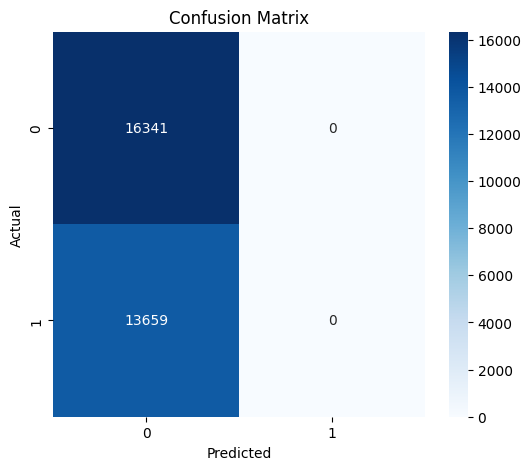

BATCH 1 out of TOTAL: 27 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/15, Train Loss: 0.4622, Val Loss: 0.5198
Epoch 2/15, Train Loss: 0.4528, Val Loss: 0.4702
Epoch 3/15, Train Loss: 0.4346, Val Loss: 0.4591
Epoch 4/15, Train Loss: 0.4433, Val Loss: 0.5066
Epoch 5/15, Train Loss: 0.4482, Val Loss: 0.4642
Epoch 6/15, Train Loss: 0.4449, Val Loss: 0.4673
Epoch 7/15, Train Loss: 0.4511, Val Loss: 0.4885
Epoch 8/15, Train Loss: 0.4425, Val Loss: 0.4805
Epoch 9/15, Train Loss: 0.4416, Val Loss: 0.4702
Epoch 10/15, Train Loss: 0.4467, Val Loss: 0.4869
Epoch 11/15, Train Loss: 0.4406, Val Loss: 0.4833
Epoch 12/15, Train Loss: 0.4488, Val Loss: 0.5033
Epoch 13/15, Train Loss: 0.4457, Val Loss: 0.5024
Epoch 14/15, Train Loss: 0.4518, Val Loss: 0.5092
Epoch 15/15, Train Loss: 0.4382, Val Loss: 0.4887
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.6047
Confusion Matrix:
[[18141     0]
 [11859     0]]


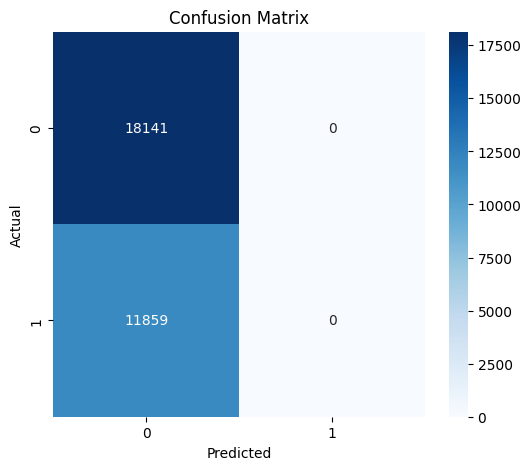

BATCH 2 out of TOTAL: 27 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/15, Train Loss: 0.4506, Val Loss: 0.4432
Epoch 2/15, Train Loss: 0.4394, Val Loss: 0.4596
Epoch 3/15, Train Loss: 0.4477, Val Loss: 0.4520
Epoch 4/15, Train Loss: 0.4534, Val Loss: 0.4645
Epoch 5/15, Train Loss: 0.4451, Val Loss: 0.4449
Epoch 6/15, Train Loss: 0.4295, Val Loss: 0.4548
Epoch 7/15, Train Loss: 0.4315, Val Loss: 0.4588
Epoch 8/15, Train Loss: 0.4424, Val Loss: 0.4745
Epoch 9/15, Train Loss: 0.4376, Val Loss: 0.4679
Epoch 10/15, Train Loss: 0.4434, Val Loss: 0.4448
Epoch 11/15, Train Loss: 0.4348, Val Loss: 0.4573
Epoch 12/15, Train Loss: 0.4398, Val Loss: 0.4464
Epoch 13/15, Train Loss: 0.4384, Val Loss: 0.4523
Epoch 14/15, Train Loss: 0.4304, Val Loss: 0.4582
Epoch 15/15, Train Loss: 0.4516, Val Loss: 0.4555
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.5949
Confusion Matrix:
[[17846     0]
 [12154     0]]


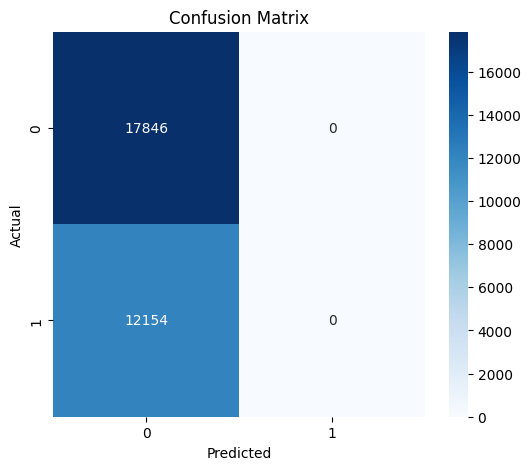

BATCH 3 out of TOTAL: 27 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/15, Train Loss: 0.4506, Val Loss: 0.4813
Epoch 2/15, Train Loss: 0.4703, Val Loss: 0.5051
Epoch 3/15, Train Loss: 0.5528, Val Loss: 0.6262
Epoch 4/15, Train Loss: 0.6058, Val Loss: 0.6207
Epoch 5/15, Train Loss: 0.5984, Val Loss: 0.6169
Epoch 6/15, Train Loss: 0.5980, Val Loss: 0.6046
Epoch 7/15, Train Loss: 0.5973, Val Loss: 0.6206
Epoch 8/15, Train Loss: 0.5994, Val Loss: 0.6081
Epoch 9/15, Train Loss: 0.5960, Val Loss: 0.6116
Epoch 10/15, Train Loss: 0.5976, Val Loss: 0.6111
Epoch 11/15, Train Loss: 0.6003, Val Loss: 0.6091
Epoch 12/15, Train Loss: 0.5978, Val Loss: 0.6163
Epoch 13/15, Train Loss: 0.5955, Val Loss: 0.6145
Epoch 14/15, Train Loss: 0.6001, Val Loss: 0.6265
Epoch 15/15, Train Loss: 0.5949, Val Loss: 0.6124
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.5909
Confusion Matrix:
[[17727     0]
 [12273     0]]


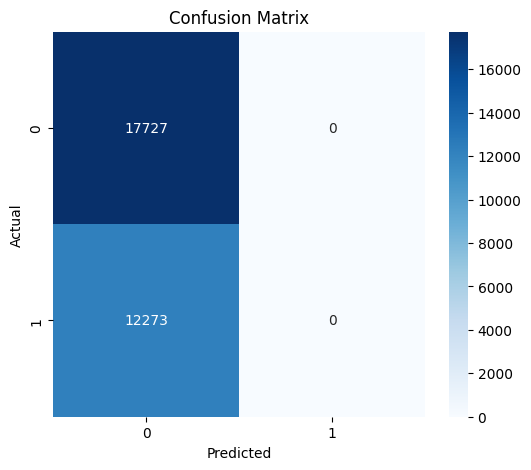

BATCH 4 out of TOTAL: 27 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/15, Train Loss: 0.6043, Val Loss: 0.6242
Epoch 2/15, Train Loss: 0.5996, Val Loss: 0.6159
Epoch 3/15, Train Loss: 0.6010, Val Loss: 0.6108
Epoch 4/15, Train Loss: 0.6050, Val Loss: 0.6237
Epoch 5/15, Train Loss: 0.6087, Val Loss: 0.6183
Epoch 6/15, Train Loss: 0.6025, Val Loss: 0.6191
Epoch 7/15, Train Loss: 0.5997, Val Loss: 0.6120
Epoch 8/15, Train Loss: 0.6008, Val Loss: 0.6140
Epoch 9/15, Train Loss: 0.5980, Val Loss: 0.6218
Epoch 10/15, Train Loss: 0.5998, Val Loss: 0.6121
Epoch 11/15, Train Loss: 0.6000, Val Loss: 0.6237
Epoch 12/15, Train Loss: 0.5997, Val Loss: 0.6331
Epoch 13/15, Train Loss: 0.6029, Val Loss: 0.6209
Epoch 14/15, Train Loss: 0.6015, Val Loss: 0.6206
Epoch 15/15, Train Loss: 0.5998, Val Loss: 0.6179
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.5760
Confusion Matrix:
[[17281     0]
 [12719     0]]


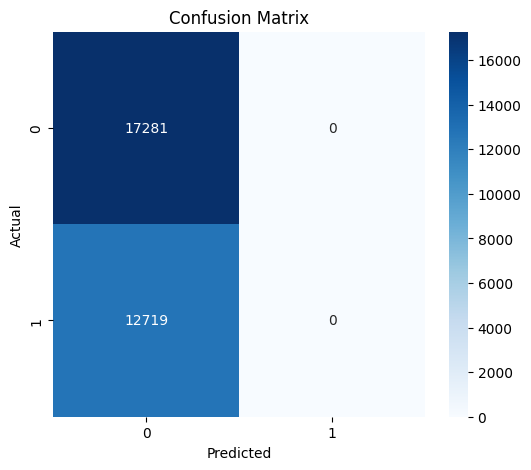

BATCH 5 out of TOTAL: 27 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/15, Train Loss: 0.6184, Val Loss: 0.6263
Epoch 2/15, Train Loss: 0.6047, Val Loss: 0.6181
Epoch 3/15, Train Loss: 0.6003, Val Loss: 0.6094
Epoch 4/15, Train Loss: 0.6007, Val Loss: 0.6208
Epoch 5/15, Train Loss: 0.6014, Val Loss: 0.6174
Epoch 6/15, Train Loss: 0.6002, Val Loss: 0.6132
Epoch 7/15, Train Loss: 0.6017, Val Loss: 0.6213
Epoch 8/15, Train Loss: 0.6005, Val Loss: 0.6139
Epoch 9/15, Train Loss: 0.5993, Val Loss: 0.6147
Epoch 10/15, Train Loss: 0.6023, Val Loss: 0.6158
Epoch 11/15, Train Loss: 0.6004, Val Loss: 0.6146
Epoch 12/15, Train Loss: 0.6004, Val Loss: 0.6085
Epoch 13/15, Train Loss: 0.6051, Val Loss: 0.6093
Epoch 14/15, Train Loss: 0.6011, Val Loss: 0.6199
Epoch 15/15, Train Loss: 0.6024, Val Loss: 0.6184
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.5704
Confusion Matrix:
[[17112     0]
 [12888     0]]


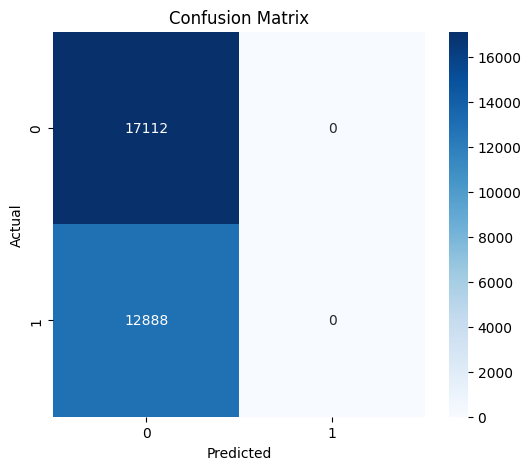

BATCH 6 out of TOTAL: 27 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/15, Train Loss: 0.6135, Val Loss: 0.6111
Epoch 2/15, Train Loss: 0.6044, Val Loss: 0.6181
Epoch 3/15, Train Loss: 0.6027, Val Loss: 0.6233
Epoch 4/15, Train Loss: 0.6022, Val Loss: 0.6242
Epoch 5/15, Train Loss: 0.6056, Val Loss: 0.6141
Epoch 6/15, Train Loss: 0.6007, Val Loss: 0.6213
Epoch 7/15, Train Loss: 0.6031, Val Loss: 0.6109
Epoch 8/15, Train Loss: 0.6038, Val Loss: 0.6113
Epoch 9/15, Train Loss: 0.6030, Val Loss: 0.6238
Epoch 10/15, Train Loss: 0.6049, Val Loss: 0.6129
Epoch 11/15, Train Loss: 0.6048, Val Loss: 0.6235
Epoch 12/15, Train Loss: 0.6017, Val Loss: 0.6117
Epoch 13/15, Train Loss: 0.6017, Val Loss: 0.6280
Epoch 14/15, Train Loss: 0.6038, Val Loss: 0.6154
Epoch 15/15, Train Loss: 0.6027, Val Loss: 0.6180
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.5370
Confusion Matrix:
[[16109     0]
 [13891     0]]


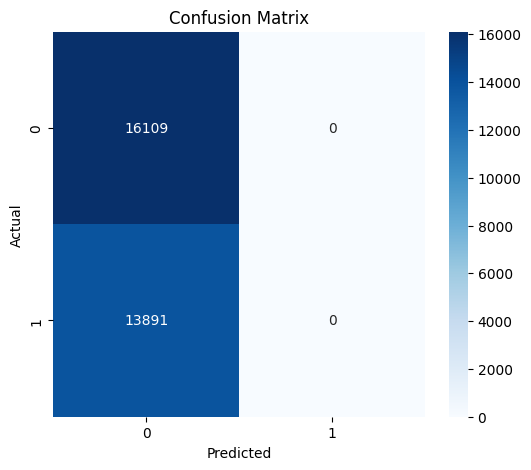

BATCH 7 out of TOTAL: 27 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/15, Train Loss: 0.6039, Val Loss: 0.6119
Epoch 2/15, Train Loss: 0.5973, Val Loss: 0.6039
Epoch 3/15, Train Loss: 0.5968, Val Loss: 0.6077
Epoch 4/15, Train Loss: 0.5964, Val Loss: 0.6174
Epoch 5/15, Train Loss: 0.5954, Val Loss: 0.6045
Epoch 6/15, Train Loss: 0.5967, Val Loss: 0.6101
Epoch 7/15, Train Loss: 0.5955, Val Loss: 0.6099
Epoch 8/15, Train Loss: 0.5961, Val Loss: 0.6083
Epoch 9/15, Train Loss: 0.5959, Val Loss: 0.5957
Epoch 10/15, Train Loss: 0.6106, Val Loss: 0.6092
Epoch 11/15, Train Loss: 0.5995, Val Loss: 0.6148
Epoch 12/15, Train Loss: 0.5964, Val Loss: 0.6070
Epoch 13/15, Train Loss: 0.5949, Val Loss: 0.6070
Epoch 14/15, Train Loss: 0.5963, Val Loss: 0.6092
Epoch 15/15, Train Loss: 0.5955, Val Loss: 0.6142
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.5863
Confusion Matrix:
[[17589     0]
 [12411     0]]


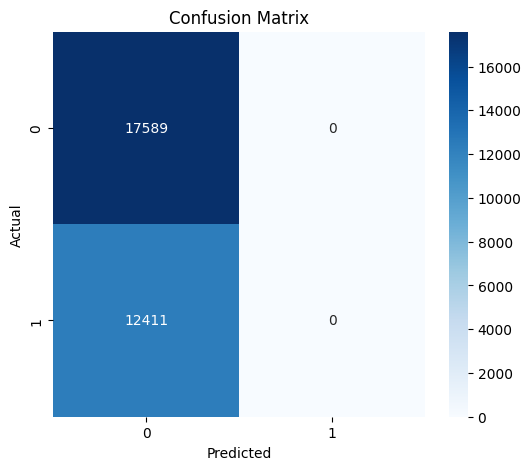

BATCH 8 out of TOTAL: 27 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/15, Train Loss: 0.6057, Val Loss: 0.6033
Epoch 2/15, Train Loss: 0.5984, Val Loss: 0.6003
Epoch 3/15, Train Loss: 0.5989, Val Loss: 0.6044
Epoch 4/15, Train Loss: 0.6014, Val Loss: 0.6199
Epoch 5/15, Train Loss: 0.5983, Val Loss: 0.6005
Epoch 6/15, Train Loss: 0.5987, Val Loss: 0.6139
Epoch 7/15, Train Loss: 0.6007, Val Loss: 0.6097
Epoch 8/15, Train Loss: 0.6003, Val Loss: 0.6047
Epoch 9/15, Train Loss: 0.5976, Val Loss: 0.6072
Epoch 10/15, Train Loss: 0.5958, Val Loss: 0.6121
Epoch 11/15, Train Loss: 0.5990, Val Loss: 0.6086
Epoch 12/15, Train Loss: 0.5981, Val Loss: 0.6068
Epoch 13/15, Train Loss: 0.6022, Val Loss: 0.6085
Epoch 14/15, Train Loss: 0.5981, Val Loss: 0.6014
Epoch 15/15, Train Loss: 0.5985, Val Loss: 0.6108
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.5985
Confusion Matrix:
[[17954     0]
 [12046     0]]


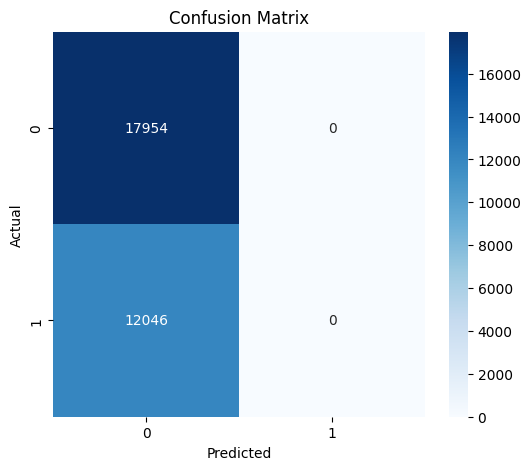

BATCH 9 out of TOTAL: 27 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/15, Train Loss: 0.6082, Val Loss: 0.6070
Epoch 2/15, Train Loss: 0.6011, Val Loss: 0.6040
Epoch 3/15, Train Loss: 0.6046, Val Loss: 0.6170
Epoch 4/15, Train Loss: 0.6014, Val Loss: 0.6064
Epoch 5/15, Train Loss: 0.6010, Val Loss: 0.6090
Epoch 6/15, Train Loss: 0.6018, Val Loss: 0.6105
Epoch 7/15, Train Loss: 0.6021, Val Loss: 0.6139
Epoch 8/15, Train Loss: 0.6034, Val Loss: 0.6133
Epoch 9/15, Train Loss: 0.6014, Val Loss: 0.6100
Epoch 10/15, Train Loss: 0.6024, Val Loss: 0.6185
Epoch 11/15, Train Loss: 0.5996, Val Loss: 0.6140
Epoch 12/15, Train Loss: 0.6005, Val Loss: 0.6143
Epoch 13/15, Train Loss: 0.6012, Val Loss: 0.6189
Epoch 14/15, Train Loss: 0.6004, Val Loss: 0.6156
Epoch 15/15, Train Loss: 0.6008, Val Loss: 0.6185
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.5836
Confusion Matrix:
[[17507     0]
 [12493     0]]


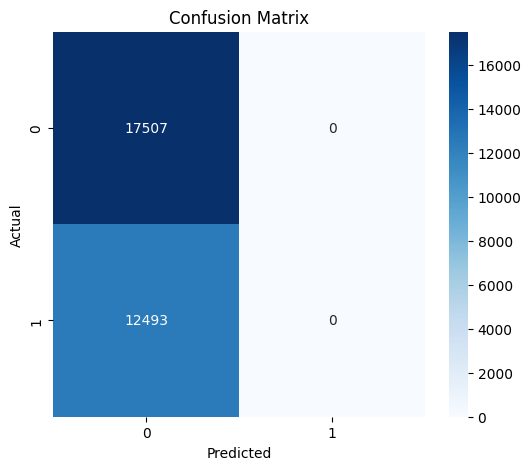

BATCH 10 out of TOTAL: 27 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/15, Train Loss: 0.6030, Val Loss: 0.6095
Epoch 2/15, Train Loss: 0.6002, Val Loss: 0.6035
Epoch 3/15, Train Loss: 0.5978, Val Loss: 0.6084
Epoch 4/15, Train Loss: 0.5984, Val Loss: 0.6133
Epoch 5/15, Train Loss: 0.5966, Val Loss: 0.6103
Epoch 6/15, Train Loss: 0.5972, Val Loss: 0.6072
Epoch 7/15, Train Loss: 0.5965, Val Loss: 0.6078
Epoch 8/15, Train Loss: 0.5951, Val Loss: 0.6019
Epoch 9/15, Train Loss: 0.6018, Val Loss: 0.6150
Epoch 10/15, Train Loss: 0.5980, Val Loss: 0.6022
Epoch 11/15, Train Loss: 0.5967, Val Loss: 0.6078
Epoch 12/15, Train Loss: 0.5969, Val Loss: 0.6062
Epoch 13/15, Train Loss: 0.5967, Val Loss: 0.6078
Epoch 14/15, Train Loss: 0.5978, Val Loss: 0.6089
Epoch 15/15, Train Loss: 0.5955, Val Loss: 0.6076
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.5737
Confusion Matrix:
[[17210     0]
 [12790     0]]


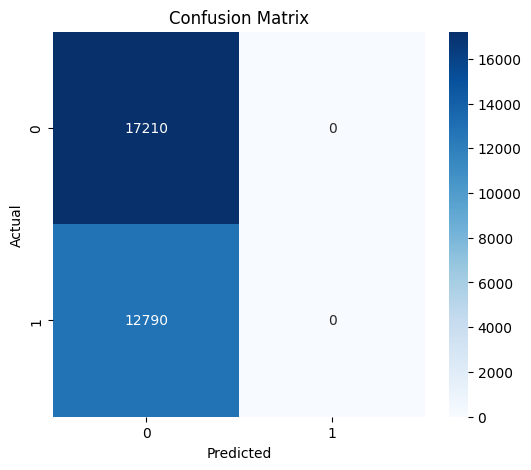

BATCH 11 out of TOTAL: 27 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/15, Train Loss: 0.6000, Val Loss: 0.6138
Epoch 2/15, Train Loss: 0.5976, Val Loss: 0.6042
Epoch 3/15, Train Loss: 0.5961, Val Loss: 0.6037
Epoch 4/15, Train Loss: 0.5977, Val Loss: 0.6111
Epoch 5/15, Train Loss: 0.5948, Val Loss: 0.6108
Epoch 6/15, Train Loss: 0.5977, Val Loss: 0.6123
Epoch 7/15, Train Loss: 0.5957, Val Loss: 0.6109
Epoch 8/15, Train Loss: 0.5965, Val Loss: 0.6097
Epoch 9/15, Train Loss: 0.5942, Val Loss: 0.6053
Epoch 10/15, Train Loss: 0.5975, Val Loss: 0.6176
Epoch 11/15, Train Loss: 0.5984, Val Loss: 0.6087
Epoch 12/15, Train Loss: 0.5962, Val Loss: 0.6052
Epoch 13/15, Train Loss: 0.5969, Val Loss: 0.6133
Epoch 14/15, Train Loss: 0.5953, Val Loss: 0.6062
Epoch 15/15, Train Loss: 0.5962, Val Loss: 0.6103
Model saved successfully as pickle file!
Training complete!
Test Accuracy: 0.6060
Confusion Matrix:
[[18179     0]
 [11821     0]]


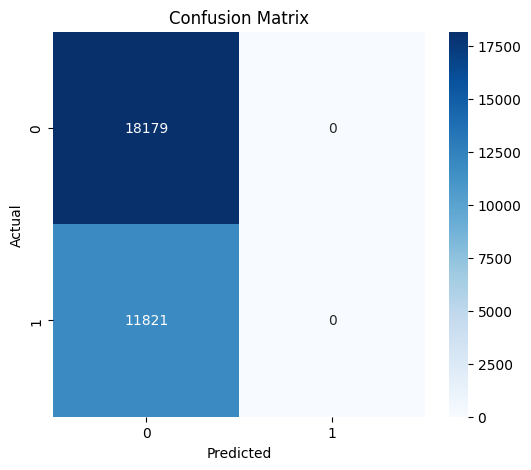

BATCH 12 out of TOTAL: 27 completed


/Users/shanujha/Desktop/voice_activity_prediction/src/vap_sound/utils/extract_mfcc_torchaudio.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  speech_probs = torch.tensor(speech_probs).squeeze(0)


Model loaded successfully from pickle file!
Epoch 1/15, Train Loss: 0.6020, Val Loss: 0.6128
Epoch 2/15, Train Loss: 0.6008, Val Loss: 0.6116
Epoch 3/15, Train Loss: 0.6004, Val Loss: 0.6076
Epoch 4/15, Train Loss: 0.5986, Val Loss: 0.6153
Epoch 5/15, Train Loss: 0.6006, Val Loss: 0.6137


KeyboardInterrupt: 

In [9]:
import numpy as np
from vap_sound.config import MFCC_SAMPLE_RATE, FUTURE_OFFSET, HOP_LENGTH, N_MFCC_PER_FRAME, BATCH_SIZE, NUM_EPOCHS, SEQ_LENGTH, LEARNING_RATE
from vap_sound.utils.extract_mfcc_torchaudio import MFCC_EXTRACTION

batch = 0
batch_file_size = 1000
total = int(len(file_df)/batch_file_size)
model = VAPModel()
mfcc_extraction = MFCC_EXTRACTION()

for i in range(0, len(file_df)-batch_file_size, batch_file_size):
    # print(i)

    ## Training ##
    train_files = file_df['file_paths'][i: i+batch_file_size]
    # print(f"Training on {len(train_files)} files")
    # print(train_files)
    #  = extract_mfcc_features(train_files)
    training_data = mfcc_extraction.extract_mfcc_features(
        audio_files = train_files,
        target_sample_rate=MFCC_SAMPLE_RATE, 
        future_offset=FUTURE_OFFSET, 
        n_mfcc=N_MFCC_PER_FRAME, 
        hop_length=HOP_LENGTH  
    )
    train_model(training_data, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, seq_length=SEQ_LENGTH, learning_rate=LEARNING_RATE)

    # ## Evaluation
    random_integer = np.random.randint(1, len(file_df)- batch_file_size)
    eval_files = file_df['file_paths'][random_integer: random_integer + 300]
    eval_data = mfcc_extraction.extract_mfcc_features(
        audio_files=eval_files, 
        target_sample_rate=MFCC_SAMPLE_RATE, 
        future_offset=FUTURE_OFFSET, 
        n_mfcc=N_MFCC_PER_FRAME, 
        hop_length=HOP_LENGTH  
    )
    eval_dataset = VAPDataset(eval_data)
    eval_dataloader = DataLoader(eval_dataset, batch_size=16, shuffle=True)
    evaluate_model(model, eval_dataloader, output_file=LOG_MODEL_EVALUATION, metrics_file=LOG_MODEL_PREDICTION)

    batch += 1
    print(f"BATCH {batch} out of TOTAL: {total} completed")

print("Training Completed")